In [65]:
import pandas as pd
import matplotlib.pyplot as plt


# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [66]:
import sqlite3

conn = sqlite3.connect("../db.sqlite3")
query = '''
    SELECT restaurant_order.id AS "order_id", restaurant_order.datetime AS "order_datetime", restaurant_product.name AS "product_name", restaurant_product.price AS "product_price", restaurant_orderitem.quantity AS "product_quantity"
    FROM restaurant_order
    JOIN restaurant_orderitem  ON restaurant_order.id = restaurant_orderitem.order_id
    JOIN restaurant_product  ON restaurant_orderitem.product_id = restaurant_product.id
'''
data = pd.read_sql_query(query, conn)
data.to_csv("combined_data.csv", index=False)

df = pd.read_csv("combined_data.csv")
df["order_datetime"] = pd.to_datetime(df["order_datetime"])
df


,order_id,order_datetime,product_name,product_price,product_quantity
0,1,2019-08-03 20:25:00,Plain Papadum,0.80,2
1,1,2019-08-03 20:25:00,King Prawn Balti,12.95,1
2,1,2019-08-03 20:25:00,Garlic Naan,2.95,1
3,1,2019-08-03 20:25:00,Mushroom Rice,3.95,1
4,1,2019-08-03 20:25:00,Paneer Tikka Masala,8.95,1
...,...,...,...,...,...
74813,3255,2016-05-18 18:53:00,House Red wine 75cl,17.95,2
74814,12905,2016-05-14 19:28:00,House Red wine 75cl,17.95,2
74815,3272,2016-05-10 13:18:00,House Red wine 75cl,17.95,2
74816,11404,2016-04-07 19:04:00,House white wine 75cl,17.95,1


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

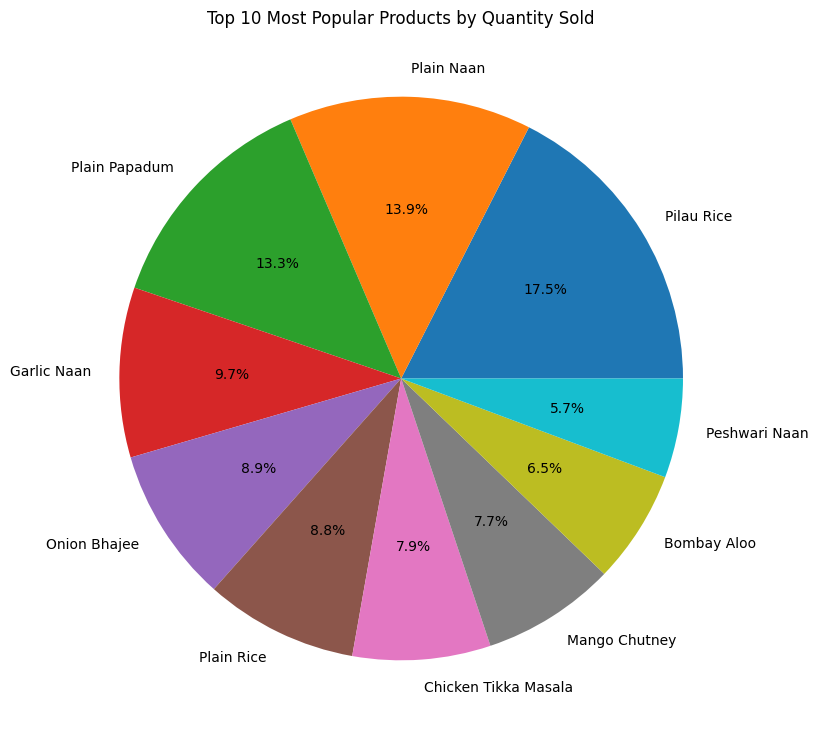

In [67]:
top_10_products = df["product_name"].value_counts().head(10)
product_counts = pd.DataFrame({"Product": top_10_products.index, "Quantity_Sold": top_10_products.values})


product_counts["Popularity_Percentage"] = (product_counts["Quantity_Sold"] / product_counts["Quantity_Sold"].sum()) * 100

plt.figure(figsize=(8, 9))
plt.pie(product_counts["Popularity_Percentage"], labels=product_counts["Product"], autopct="%1.1f%%")
plt.title("Top 10 Most Popular Products by Quantity Sold")
plt.axis("equal")
plt.show()


# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

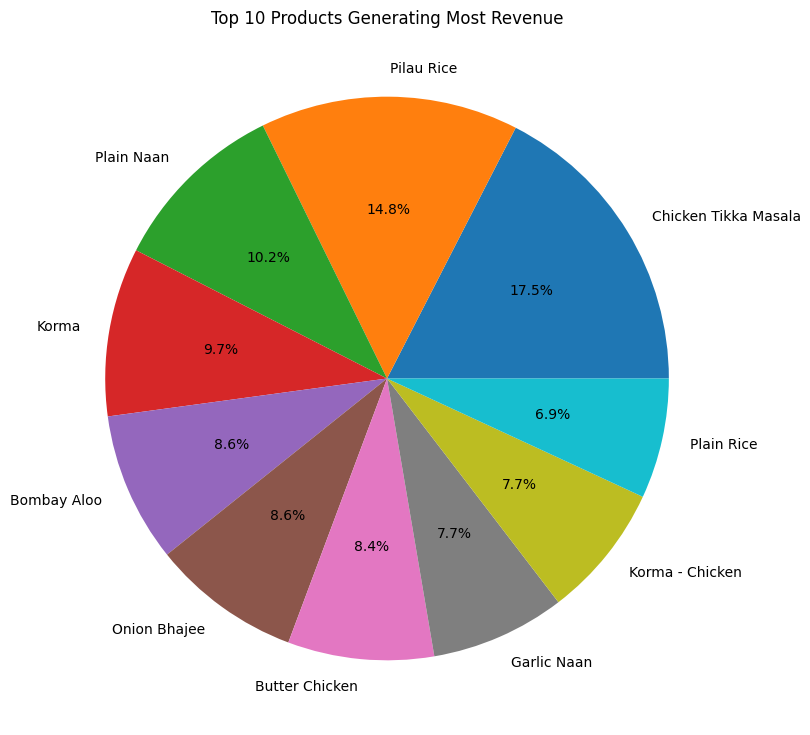

In [68]:
df["Item_Price"] = df["product_price"] * df["product_quantity"]
top_10_revenue_products = df.groupby("product_name")["Item_Price"].sum().nlargest(10)

revenue_product_counts = pd.DataFrame({"Product": top_10_revenue_products.index, "Total_Revenue": top_10_revenue_products.values})

revenue_product_counts["Revenue_Percentage"] = (revenue_product_counts["Total_Revenue"] / revenue_product_counts["Total_Revenue"].sum()) * 100

plt.figure(figsize=(8, 9))
plt.pie(revenue_product_counts["Revenue_Percentage"], labels=revenue_product_counts["Product"], autopct="%1.1f%%")
plt.title("Top 10 Products Generating Most Revenue")
plt.axis("equal")
plt.show()


# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

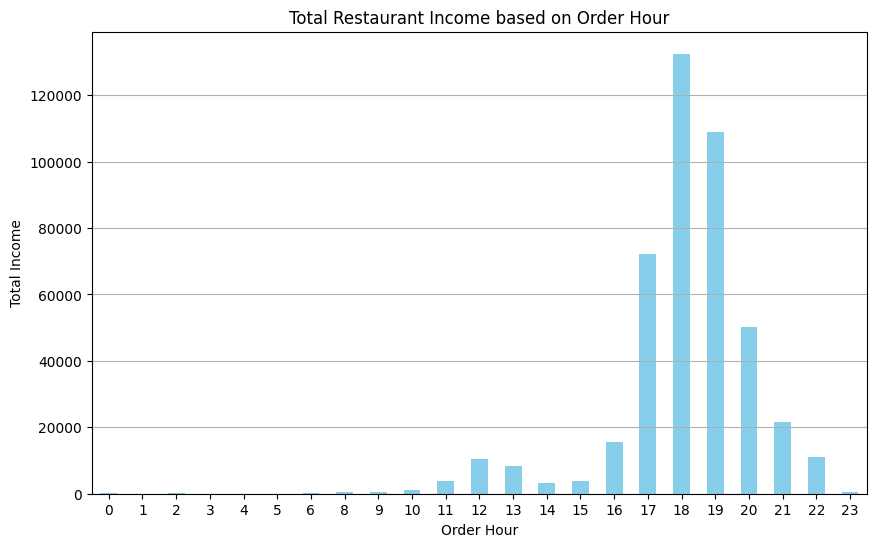

In [69]:
df["Order_Hour"] = df["order_datetime"].dt.hour
hourly_income = df.groupby("Order_Hour")["Item_Price"].sum()

plt.figure(figsize=(10, 6))
hourly_income.plot(kind="bar", color="skyblue")
plt.xlabel("Order Hour")
plt.ylabel("Total Income")
plt.title("Total Restaurant Income based on Order Hour")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

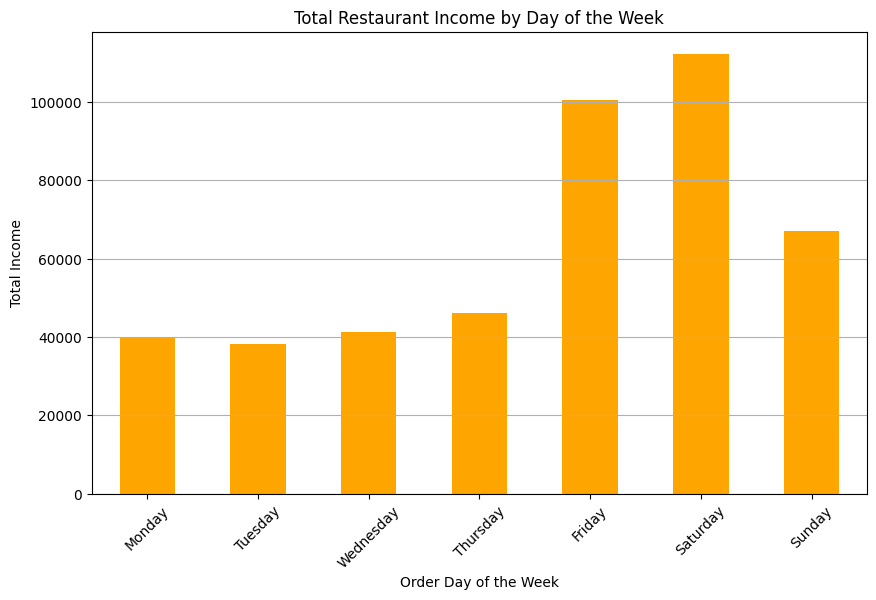

In [70]:
df["Order_Day_of_Week"] = df["order_datetime"].dt.dayofweek

day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["Order_Day_Name"] = df["Order_Day_of_Week"].map(lambda x: day_names[x])

daily_income = df.groupby("Order_Day_Name")["Item_Price"].sum()

plt.figure(figsize=(10, 6))
daily_income = daily_income.reindex(day_names)
daily_income.plot(kind="bar", color="orange")
plt.xlabel("Order Day of the Week")
plt.ylabel("Total Income")
plt.title("Total Restaurant Income by Day of the Week")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()
